# Exercise Solution: Synthetic Data (Stroke Thromobolysis Dataset) 

### Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.neighbors import NearestNeighbors

# Import package for SMOTE
import imblearn

# import SMOTE from imblearn so we can use it
from imblearn.over_sampling import SMOTE

# Turn warnings off to keep notebook clean
import warnings
warnings.filterwarnings("ignore")

### Read CSV into Pandas DataFrame

In [2]:
data = pd.read_csv('data/processed_stroke.csv')
# Make all data 'float' type and drop ID
data = data.astype(float)
data.drop('id', axis=1, inplace=True) # Remove ID column

### Record number in each class

In [3]:
# Record number in each class
number_positive_stroke = np.sum(data['stroke'] == 1)
number_negative_stroke = np.sum(data['stroke'] == 0)

print (f"Positives : {number_positive_stroke}")
print (f"Negatives : {number_negative_stroke}")

Positives : 209
Negatives : 4700


### Divide into X (features) and y (labels)

In [4]:
X = data.drop('stroke',axis=1) # X = all 'data' except the 'stroke' column
y = data['stroke'] # y = 'stroke' column from 'data'

### Divide into training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Show examples from the training data

In [6]:
X_train.head()

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown
4502,1.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,97.68,47.1,0.0,1.0,0.0,0.0
1752,1.0,0.0,0.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.61,22.0,0.0,0.0,1.0,0.0
4317,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72.76,18.8,0.0,0.0,0.0,1.0
1538,0.0,1.0,0.0,53.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,83.79,44.0,0.0,0.0,0.0,1.0
1912,0.0,1.0,0.0,50.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,95.01,26.2,0.0,1.0,0.0,0.0


### Standardise data

In [7]:
def standardise_data(X_train, X_test):

    # Initialise a new scaling object for normalising input data
    sc = StandardScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)

    return train_std, test_std

In [8]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

### Fit Logistic Regression model

In [9]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

### Use fitted model to make predictions on training and test set data

In [10]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

### Calculate accuracy

In [11]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.958
Accuracy of predicting test data = 0.957


### Function to create synthetic data

In [12]:
def make_synthetic_data_smote(X, y, number_of_samples=[1000,1000]):
    """
    Synthetic data generation for two classes.

    Inputs
    ------
    original_data: X, y numpy arrays (y should have label 0 and 1)
    number_of_samples: number of samples to generate (list for y=0, y=1)
    (Note - number_of_samples has default of 1000 samples for each class
    if no numbers are specified at the point of calling the function)

    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """

    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)

    # SMOTE requires final class counts; add current counts to required counts
    # (which are passed into the function)
    n_class_0 = number_of_samples[0] + count_label_0
    n_class_1 = number_of_samples[1] + count_label_1

    # Use SMOTE to sample data points.  The number of points that we pass over
    # to SMOTE is calculated above (the number of synthetic data samples we
    # want, which we passed into the function + the counts from the original
    # data).  This tells SMOTE how many TOTAL data points are needed (original
    # + synthetic) for each class.  It then uses the original data to generate
    # new synthetic data points.
    # For example, imagine our original data has 100 samples for class 0 and 50
    # for class 1, and we tell SMOTE we want 100 synthetic data points for
    # class 0 and 150 synthetic data points for class 1.  We tell SMOTE that we
    # need a total of 200 data points for class 0 (100 original + 100 synthetic)
    # and 200 data points for class 1 (50 original + 150 synthetic).  It will
    # then fill those data points by taking the original data (which will fill
    # up the first 100 "slots" for class 0, and the first 50 "slots" for class 1)
    # and then use these original data points to sample new synthetic data points
    # to fill the remaining "slots" in each class.
    X_resampled, y_resampled = SMOTE(
        sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)

    # Get just the additional (synthetic) data points.  By using len(X) for the
    # X (input feature) data, and len(y) for the y (output label) data, we skip
    # the original data, and just start from the newly created synthetic data,
    # generated by SMOTE (above)
    X_synthetic = X_resampled[len(X):]
    y_synthetic = y_resampled[len(y):]

    return X_synthetic, y_synthetic

### Generate raw synthetic data

In [13]:
# Get counts of classes from y_train
unique, original_frequency = np.unique(y_train, return_counts = True)
required_smote_count = list(original_frequency * 2)

In [14]:
# Call the function we wrote above to generate and extract the synthetic data
X_synthetic, y_synthetic = make_synthetic_data_smote(
        X_train, y_train, number_of_samples=required_smote_count)

In [15]:
X_synthetic.head()

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown
3681,1.000000,0.000000,0.0,5.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,99.779906,17.148605,0.0,0.0,0.0,1.0
3682,0.431466,0.568534,0.0,13.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.568534,76.816507,20.868534,0.0,0.0,0.0,1.0
3683,0.688153,0.311847,0.0,70.311847,0.311847,0.0,1.0,0.0,0.688153,0.311847,0.0,0.0,0.000000,222.470035,34.268815,0.0,1.0,0.0,0.0
3684,0.375244,0.624756,0.0,1.529825,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,164.704902,16.825731,0.0,0.0,0.0,1.0
3685,0.000000,1.000000,0.0,33.765655,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.234345,133.224763,21.501422,0.0,0.0,1.0,0.0


### Prepare lists of categorical, integer and binary features

In [16]:
# Get full list of column names (the names of our features)
X_col_names = list(X_train)

# Set categorical one-hots cols using common prefix
categorical = ['gender_', 'work_type_', 'smoking_status_']

one_hot_cols = []
for col in categorical:
    one_hot_cols.append([x for x in X_col_names if x[0:len(col)] == col])

# Set integer columns
integer_cols = ['age']

# Set binary columns
binary_cols = ['hypertension',
               'heart_disease',
               'ever_married',
               'residence_type_rural']

### Function to process raw synthetic categorical data to one-hot encoded

In [17]:
def make_one_hot(x):
    """
    Takes a list/array/series and turns it into a one-hot encoded
    list/array series, by setting 1 for highest value and 0 for all
    others

    """
    # Get argmax (this returns the index of the highest values in
    # the list / array / series passed in to the function)
    highest = np.argmax(x)
    # Set all values to zero (just multiply all values by 0)
    x *= 0.0
    # Set the value that was found to be the highest to 1, by
    # using the index we found using argmax above
    x[highest] = 1.0

    return x

### Process raw synthetic data and show a sample

In [18]:
# Set y_label
y_label = 'stroke'

# Create a data frame with id to store the synthetic data
synth_df = pd.DataFrame()

# Transfer X values to the new DataFrame
synth_df=pd.concat([synth_df,
                    pd.DataFrame(X_synthetic, columns=X_col_names)],
                    axis=1)

# Make columns (that need to be) one hot encoded using the
# function we wrote above, using the raw synthetic data
for one_hot_list in one_hot_cols:
    for index, row in synth_df.iterrows():
        x = row[one_hot_list]
        x_one_hot = make_one_hot(x)
        row[x_one_hot.index]= x_one_hot.values

# Make integer as necessary by rounding the raw synthetic data
for col in integer_cols:
    synth_df[col] = synth_df[col].round(0)

# Round binary cols and clip so values under 0 or above 1
# are set to 0 and 1 respectively (this won't happen with
# SMOTE, as it will only sample between the two points (so
# points sampled between binary points will always be
# between 0 and 1) but it can happen with other methods)
for col in binary_cols:
    synth_df[col] = np.clip(synth_df[col],0,1).round(0)

# Add y data with a label
y_list = list(y_synthetic)
synth_df[y_label] = y_list

# Shuffle data
synth_df = synth_df.sample(frac=1.0)

In [19]:
synth_df.head()

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown,stroke
11029,1.0,0.0,0.0,66.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,76.595595,21.341845,0.0,1.0,0.0,0.0,1.0
8917,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,86.177242,16.819550,0.0,0.0,0.0,1.0,0.0
7515,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,98.342804,19.927970,0.0,0.0,0.0,1.0,0.0
10261,0.0,1.0,0.0,68.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,111.693441,26.023267,0.0,0.0,1.0,0.0,0.0
3956,1.0,0.0,0.0,57.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,71.070423,25.928229,0.0,1.0,0.0,0.0,0.0


### Find nearest original data point to each synthetic data point

In [20]:
# Standardise synthetic data (based on real training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
# We do this because we need to check for duplicates / very close
# values in all of the real data we've got
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)

# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point. First, we fit to the real standardised data
# (all of it, train + test set).  Then we can give it the synthetic data
# and ask it to give us the cartesian distance and ID of its nearest
# real world data point neighbour for each synthetic data point.
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the index and ids (indices) in the synthetic data DataFrame
# Flatten just reduces something in more than 1 dimension down to
# 1 dimension (eg a list of lists becomes a single list)
synth_df['distance_to_closest_real'] = list(dists.flatten())
synth_df['closest_X_real_row_index'] = list(idxs.flatten())

In [21]:
synth_df

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,...,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown,stroke,distance_to_closest_real,closest_X_real_row_index
11029,1.0,0.0,0.0,66.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,76.595595,21.341845,0.0,1.0,0.0,0.0,1.0,0.017891,3246
8917,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,86.177242,16.819550,0.0,0.0,0.0,1.0,0.0,1.512034,527
7515,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,98.342804,19.927970,0.0,0.0,0.0,1.0,0.0,1.901454,2592
10261,0.0,1.0,0.0,68.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,111.693441,26.023267,0.0,0.0,1.0,0.0,0.0,1.088711,2726
3956,1.0,0.0,0.0,57.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,71.070423,25.928229,0.0,1.0,0.0,0.0,0.0,0.489179,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,131.403461,31.684226,0.0,0.0,1.0,0.0,0.0,0.295965,3612
9031,0.0,1.0,0.0,36.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,60.107014,24.100000,0.0,0.0,0.0,1.0,0.0,0.378650,2951
5755,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,96.518722,33.282594,0.0,0.0,0.0,1.0,0.0,1.831434,3521
9023,0.0,1.0,0.0,66.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,210.940018,23.934760,0.0,0.0,1.0,0.0,0.0,0.758766,3469


### Remove identical points

In [22]:
# Get points with zero distance to real (use distance of <0.001 as effectively identical)
identical = synth_df['distance_to_closest_real'] < 0.001

print (f'Proportion of data points identical to real data points = {identical.mean():0.3f}')
# Remove points with zero (or effectively zero) distance to a real data point.  We
# do this by setting up a mask that says we only want to see data points where the "identical"
# criterion we specified above is false (ie they're not identical).  Then we apply that
# mask and overwrite our existing synthetic data DataFrame so we've now only got data points
# that are not identical to real world data points.
mask = identical == False
synth_df = synth_df[mask]

Proportion of data points identical to real data points = 0.001


### Remove points closest to original data

In [23]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at
# the top
synth_by_distance = synth_df.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data.  Calculate the number of entries to keep as being the
# total number of synthetic data points we've now got (after having
# removed ones identical to real world data points) multiplied by
# the proportion we want to keep (the inverse of the proportion to remove).
# As we've sorted in descending order by distance, we can then just
# use .head to identify how much of the top of list we want to keep
# (90% in this case, where we're removing the 10% that are closest - at
# the bottom)
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth_df = synth_by_distance.sample(frac=1)

### Show five examples with their closest data points in the original data

In [24]:
# Reproduce X_real but with non-standardised (ie the raw original) values for
# comparison
X_real = np.concatenate([X_train, X_test], axis=0)

# Set up Data Frame for comparison
comparison = pd.DataFrame(index=X_col_names)

# Generate five examples
for i in range(5):
    # Get synthetic data sample (sample size of 1 - one data point)
    sample = synth_df.sample(1)
    comparison[f'Synthetic_{i+1}'] = sample[X_col_names].values[0]
    # Get closest point from the real data (remember we stored earlier
    # the index of the closest real world point, so we can grab it out
    # easily here)We remove
    closest_id = sample['closest_X_real_row_index']
    comparison[f'Synthetic_{i+1}_closest'] = X_real[closest_id, :][0]

# Display the comparisons
comparison.round(0)

,Synthetic_1,Synthetic_1_closest,Synthetic_2,Synthetic_2_closest,Synthetic_3,Synthetic_3_closest,Synthetic_4,Synthetic_4_closest,Synthetic_5,Synthetic_5_closest
gender_male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
gender_female,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
gender_other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,19.0,80.0,58.0,79.0,43.0,67.0,70.0,59.0,23.0,48.0
hypertension,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ever_married,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
work_type_private,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
work_type_self_employed,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
work_type_govt_job,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Sample from synthetic data to get same size / balance as the original data, and compare counts to ensure identical to original data

In [25]:
# Randomly sample from the synthetic data those who had a stroke,
# and sample this the same number of times as we had number
# who had a stroke in the real data
mask = synth_df['stroke'] == 1
synth_positive_stroke = synth_df[mask].sample(number_positive_stroke)

# The same as above, but for those who didn't have a stroke
mask = synth_df['stroke'] == 0
synth_negative_stroke = synth_df[mask].sample(number_negative_stroke)

# Reconstruct into synth_df and shuffle
synth_df = pd.concat([synth_positive_stroke, synth_negative_stroke], axis=0)
synth_df = synth_df.sample(frac=1.0, )

In [26]:
print ('Number of real data stroke : ', np.sum(data['stroke'] == 1))
print ('Number of synthetic data stroke : ', np.sum(synth_df['stroke'] == 1))
print ('Number of real data non-stroke : ', np.sum(data['stroke'] == 0))
print ('Number of synthetic data non-stroke : ', np.sum(synth_df['stroke'] == 0))

Number of real data stroke :  209
Number of synthetic data stroke :  209
Number of real data non-stroke :  4700
Number of synthetic data non-stroke :  4700


### Fit Logistic Regression model using synthetic data and compare accuracy with model trained on original data

In [27]:
# Get X data and standardised
X_synth = synth_df[X_col_names]
y_synth = synth_df['stroke'].values
X_synth_std, X_test_std = standardise_data(X_synth, X_test)

# Fit model
model_synth = LogisticRegression()
model_synth.fit(X_synth_std,y_synth)

# Get predictions of test set
y_pred_test_synth = model_synth.predict(X_test_std)

# Report accuracy
accuracy_test_synth = np.mean(y_pred_test_synth == y_test)

print (f'Accuracy of predicting test data from model trained on real data = {accuracy_test:0.3f}')
print (f'Accuracy of predicting test data from model trained on synthetic data = {accuracy_test_synth:0.3f}')

Accuracy of predicting test data from model trained on real data = 0.957
Accuracy of predicting test data from model trained on synthetic data = 0.957


### ROC Curves

In [28]:
y_probs = model.predict_proba(X_test_std)[:,1]
y_probs_synthetic = model_synth.predict_proba(X_test_std)[:,1]

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_synth, tpr_synth, thresholds_synth = roc_curve(y_test, y_probs_synthetic)
roc_auc = auc(fpr, tpr)
roc_auc_snth = auc(fpr_synth, tpr_synth)
print (f'ROC AUC real training data: {roc_auc:0.2f}')
print (f'ROC AUC synthetic training data: {roc_auc_snth:0.2f}')

ROC AUC real training data: 0.83
ROC AUC synthetic training data: 0.83


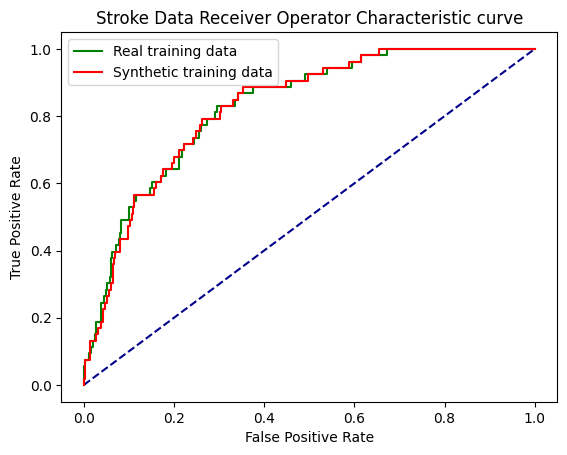

In [30]:
fig, ax = plt.subplots()

# Plot ROC
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax.plot(fpr,tpr, color='green', label = 'Real training data')
ax.plot(fpr_synth,tpr_synth, color='red', label = 'Synthetic training data')

ax.set_title('Stroke Data Receiver Operator Characteristic curve')

ax.legend()

fig.savefig('synthetic_roc.png')
fig.show()

### Use synthetic data for positive class to generate another 2000 for this class.

In [31]:
# Generate synthetic data again, but this time with 4000 extra synthetic data
# points for the positive class (double what we need), and 0 for the negative
# class
X_synthetic, y_synthetic = make_synthetic_data_smote(
    X_train, y_train, number_of_samples=[0, 4000]
)

In [32]:
# Set y_label
y_label = 'stroke'

# Create a data frame with id to store the synthetic data
synth_df = pd.DataFrame()

# Transfer X values to the new DataFrame
synth_df=pd.concat([synth_df,
                    pd.DataFrame(X_synthetic, columns=X_col_names)],
                    axis=1)

# Make columns (that need to be) one hot encoded using the
# function we wrote above, using the raw synthetic data
for one_hot_list in one_hot_cols:
    for index, row in synth_df.iterrows():
        x = row[one_hot_list]
        x_one_hot = make_one_hot(x)
        row[x_one_hot.index]= x_one_hot.values

# Make integer as necessary by rounding the raw synthetic data
for col in integer_cols:
    synth_df[col] = synth_df[col].round(0)

# Round binary cols and clip so values under 0 or above 1
# are set to 0 and 1 respectively (this won't happen with
# SMOTE, as it will only sample between the two points (so
# points sampled between binary points will always be
# between 0 and 1) but it can happen with other methods)
for col in binary_cols:
    synth_df[col] = np.clip(synth_df[col],0,1).round(0)

# Add y data with a label
y_list = list(y_synthetic)
synth_df[y_label] = y_list

# Shuffle data
synth_df = synth_df.sample(frac=1.0)

In [33]:
# Standardise synthetic data (based on real training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
# We do this because we need to check for duplicates / very close
# values in all of the real data we've got
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)

# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point. First, we fit to the real standardised data
# (all of it, train + test set).  Then we can give it the synthetic data
# and ask it to give us the cartesian distance and ID of its nearest
# real world data point neighbour for each synthetic data point.
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the index and ids (indices) in the synthetic data DataFrame
# Flatten just reduces something in more than 1 dimension down to
# 1 dimension (eg a list of lists becomes a single list)
synth_df['distance_to_closest_real'] = list(dists.flatten())
synth_df['closest_X_real_row_index'] = list(idxs.flatten())

In [34]:
# Get points with zero distance to real (use distance of <0.001 as effectively identical)
identical = synth_df['distance_to_closest_real'] < 0.001

print (f'Proportion of data points identical to real data points = {identical.mean():0.3f}')
# Remove points with zero (or effectively zero) distance to a real data point.  We
# do this by setting up a mask that says we only want to see data points where the "identical"
# criterion we specified above is false (ie they're not identical).  Then we apply that
# mask and overwrite our existing synthetic data DataFrame so we've now only got data points
# that are not identical to real world data points.
mask = identical == False
synth_df = synth_df[mask]

Proportion of data points identical to real data points = 0.001


In [35]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at
# the top
synth_by_distance = synth_df.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data.  Calculate the number of entries to keep as being the
# total number of synthetic data points we've now got (after having
# removed ones identical to real world data points) multiplied by
# the proportion we want to keep (the inverse of the proportion to remove).
# As we've sorted in descending order by distance, we can then just
# use .head to identify how much of the top of list we want to keep
# (90% in this case, where we're removing the 10% that are closest - at
# the bottom)
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth_df = synth_by_distance.sample(frac=1)

In [36]:
# Keep only a random sample of 2000 of the remaining synthetic datapoints
# We don't need a mask here as ALL our synthetic datapoints are for class 1
# (positive).
synth_df = synth_df.sample(2000)

In [37]:
# Add synthetic data for positive class (class 1) to real data
# We'll make a separate copy of the original dataframe with the new synthetic
# data points added, keeping our original data intact.
augmented_data = pd.concat([data, synth_df])

# We'll also get rid of the two columns we added -
# distance_to_closest_real and closest_X_real_row_index as we do not want these
# to be used in a Logistic Regression model.
augmented_data.drop('distance_to_closest_real', axis=1, inplace=True)
augmented_data.drop('closest_X_real_row_index', axis=1, inplace=True)


In [38]:
# Let's have a look at our new dataframe.  We should have 6,909 records (the
# original 4,909 + 2,000 additional ones for class 1 (positive)) and 20 columns
augmented_data

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown,stroke
0,1.0,0.0,0.0,67.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,228.690000,36.600000,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,80.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,105.920000,32.500000,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,49.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,171.230000,34.400000,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,79.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,174.120000,24.000000,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,81.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,186.210000,29.000000,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,1.0,0.0,0.0,76.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,130.633158,25.249173,0.0,1.0,0.0,0.0,1.0
4560,1.0,0.0,0.0,81.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,97.955702,33.567697,0.0,0.0,1.0,0.0,1.0
4276,1.0,0.0,0.0,50.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,101.679233,29.784617,1.0,0.0,0.0,0.0,1.0
7584,0.0,1.0,0.0,78.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,107.656949,30.885320,0.0,0.0,1.0,0.0,1.0


In [39]:
# Let's also check that the class splits are as expected (we should have 2,209
# positives, and 4,700 negatives)
number_positive_stroke = np.sum(augmented_data['stroke'] == 1)
number_negative_stroke = np.sum(augmented_data['stroke'] == 0)

print (f"Positives : {number_positive_stroke}")
print (f"Negatives : {number_negative_stroke}")

Positives : 2209
Negatives : 4700


In [40]:
X = augmented_data.drop('stroke',axis=1) # X = all 'data' except the 'stroke' column
y = augmented_data['stroke'] # y = 'stroke' column from 'data'

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [42]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

In [43]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

In [44]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

In [45]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.794
Accuracy of predicting test data = 0.789


It looks like adding 2,000 extra synthetic datapoints to our positive class has worsened model performance in this instance.  We probably didn't need to do in this example - we already had very good performance.  And 2,000 may have been too many to generate from a sample of around 200.